<h1>Provenance-Aware Integrity Monitoring with 
    Linux Security Identifiers
</h1>
<br>
<br>
<br>
<br>
<br>
<br>
<h3 style="color:gray"><strong>Linux Foundation</strong></h3>
<h3><strong>Linux Security Summit North America 2024</strong></h3>
<br>
<br>
<br>


<h4 style="color:gray">IBM Research</h4>

In [ ]:
#@title Initial Colab setup...

# remove colab sample_data
!rm -rf sample_data/

# download datasets
!rm -rf /tmp/sf-lab; git clone https://github.com/sysflow-telemetry/sf-lab.git /tmp/sf-lab

# add symlink to working directory
!unlink data; ln -s /tmp/sf-lab/pynb/data data
!unlink policies; ln -s /tmp/sf-lab/pynb/policies policies

# install sysflow tooling
!pip install 'sysflow-tools@git+https://github.com/sysflow-telemetry/sf-apis.git@0.5.1-selinux-labels#subdirectory=py3'

# install colab-xterm for interactive terminal
!pip install colab-xterm

# install jq cli
!apt-get install jq

In [ ]:
import sys, os, json
import numpy as np
import pandas as pd
import plotly.express as px

from sysflow.graphlet import Graphlet, EVT_FIELDS, SID_FIELDS, TAGS_FIELDS

pd.set_option('display.expand_frame_repr', False)
pd.set_option('max_colwidth', None)

cols = EVT_FIELDS + SID_FIELDS + TAGS_FIELDS

data='data/lss/crond-httpd/1713310807'

## Agenda

### Part 1: SysFlow provenance collection

### Part 2: Provenace tracking with Security Identifiers

## SysFlow Provenance Collection

In [ ]:
# Build the system provenance graph from the sysflow traces (data). Define tagging rules as declarative yaml files. 
g = Graphlet(data, defs=['policies/integrity.yaml', 'policies/ttps.yaml'])

In [ ]:
# Whole-system proveance graph
g.view()

In [ ]:
# A treemap visualization of system behaviors
df = g.data()
container_type = df.groupby(['proc.exe','proc.args','pproc.exe','type','res']).size().reset_index(name='count')
cluster = px.treemap(container_type, path=['proc.exe','type','res'], values='count',
                  color='type', 
                  hover_data=['proc.exe','proc.args','pproc.exe','type','res'], 
                  color_discrete_sequence=px.colors.qualitative.Plotly) 
cluster.show()

In [ ]:
# The number of records in this provenance graph is too large for meaningful security analysis. 
g.data().shape

In [ ]:
# We could filter the records by looking for specific processes...
df = g.data()[cols]
df[df['proc.exe'].str.contains('apache2')]

## Provenance tracking with security identifiers
- **Behavioral graphlets**
  - Compact provenance graphs
  - Coalesce process events, file flows, and network flows based on control flow path
- **Security labels derived from attack graphs**
  - Enhance the semantics of the provenance graph stream with access control labels 
  - Compute integrity boundaries between processes  
- **Security analysis**
  - Enable algorithmic attack detection
  - Attacker (attack operations) and victim behaviors (victim uses) are captured and used to detect attacks

## Integrity rules

```
- rule: Low Integrity Object
  desc: Labels an object as low integrity based on its security identifier
  condition: sf.file.selabel pmatch (low_integrity_object_identifiers)    
  action: [tag]
  tags: [integrity:low]
  
- rule: High Integrity Object
  desc: Labels an object as high integrity based on its security identifier
  condition: sf.proc.selabel pmatch (potential_victim_identifiers)
  action: [tag]
  tags: [integrity:high]
  
- rule: Potential Network Attack Vector
  desc: Labels an object as high integrity based on its security identifier
  condition: sf.proc.selabel pmatch (potential_network_attack_vector_identifiers)
  action: [tag]
  tags: [vector:network]
```



## Attack Scenario: Shellshock (CVE-2014–6271)
<center>
    <img style="margin:0px; width:80%; padding:150px;" src="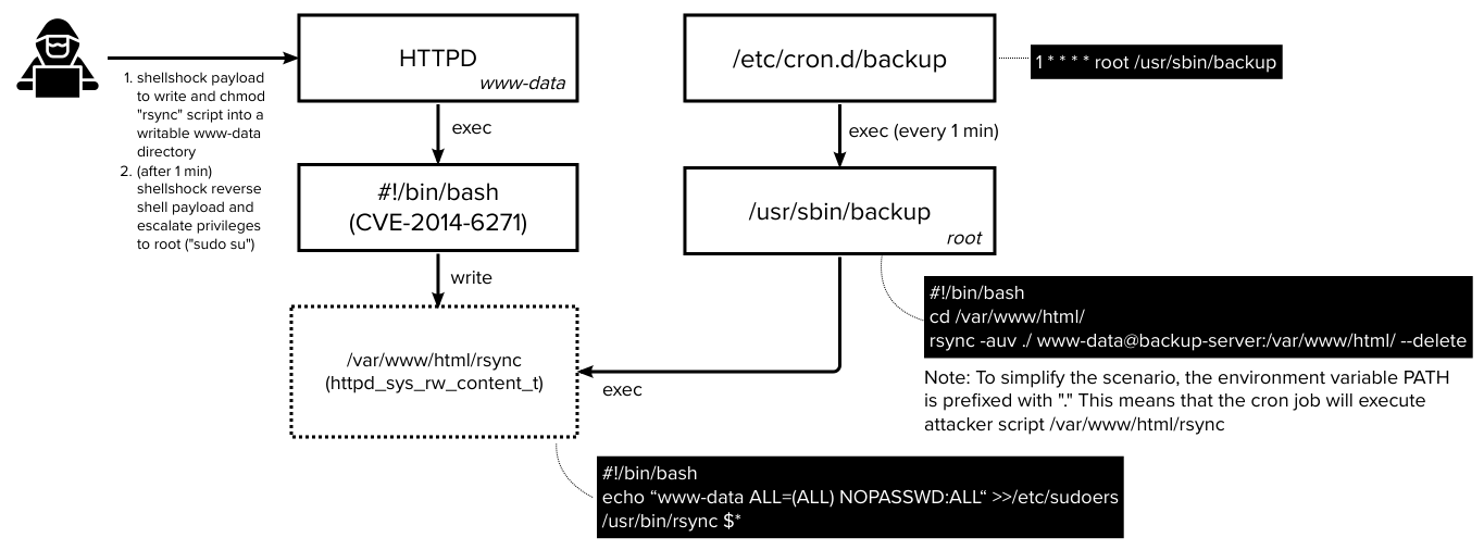
"/>
</center>

## Searching for security integrity violations

In [ ]:
# Use security identifiers to find integrity policy violations (e.g., low integrity objects affecting higher integrity victim processes)
def low_integrity_object(df):    
    return len(df[(df['tags'].astype(str).str.contains('integrity:low'))])>0

def potential_victim_process(df): 
    return len(df[(df['tags'].astype(str).str.contains('integrity:high'))])>0


proc = lambda n: potential_victim_process(n.df())
obj = lambda n: low_integrity_object(n.df())

g1 = g.findPaths(proc, obj, prune=True) \
      .attackGraph() 

In [ ]:
g1.view(withoid=True, ttps=True)

## Uncover the complete attack

In [ ]:
def low_integrity_object(df):    
    return len(df[(df['tags'].astype(str).str.contains('integrity:low'))])>0

def potential_victim_process(df): 
    return len(df[(df['tags'].astype(str).str.contains('integrity:high'))])>0

def potential_attack_vector(df): 
    return len(df[(df['tags'].astype(str).str.contains('vector:network'))])>0


proc = lambda n: potential_victim_process(n.df()) or potential_attack_vector(n.df())
obj = lambda n: low_integrity_object(n.df())

g2 = g.findPaths(proc, obj, prune=True) \
      .attackGraph() 

In [ ]:
g2.view(withoid=True, ttps=True)

## TTPs are automatically tagged to individual behaviors using policies
```
- rule: Suspicious process spawned
  desc: Suspicious behavior observed in application spawning another process
  condition: sf.type = PE and sf.opflags = EXEC 
             and sf.proc.exe != sf.pproc.exe 
             and not allowed_launchers 
             and sf.proc.name in (shell_binaries, compilers, ...)
             and not entrypoint
  action: [tag]
  priority: medium
  tags: [mitre:T1106, mitre:T1574]
```

In [ ]:
# List all unique TTPs associated with the above attack graph
g2.ttps()

In [ ]:
# List the graph nodes
g2.df()

In [ ]:
# Find the precise attack infection point
g2.data(65321136429100581067644650506733540373)[['proc.exe','proc.env']]